# Logistic Regression

The problem description and dataset are located in `data/fashion-mnist-readme.txt`. The dataset is in the files `/data/fashion-mnist_train.csv` and `/data/fashion-mnist_train.csv`. A logistic regression model will be applied to predict the class label of each fashion item (the first column of the dataset), using the values in the other columns as inputs.

The implementation will be done using NumPy functions and will utilize vectorized computation as much as possible.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Union
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Logistic Regression - Theoretical Concepts

**Linear regression** 'fits' a linear (polynomial) function using a dataset $X$ over the entire domain $\mathbb{R}$, $linreg(x) : \mathbb{R}^m \rightarrow \mathbb{R}$.

**Logistic regression** has the same domain, but its codomain is much more restricted, specifically $logreg(x) : \mathbb{R}^n \rightarrow (0, 1)$.
The codomain $(0,1)$ is due to the fact that logistic regression tries to predict the probability that the element $x \in X$ belongs to the positive class.

This probability is denoted as $P(y=1|x,\theta)$ and is interpreted as the probability associated with the response $x^T \theta$ calculated by classical regression, under the conditions that we know the features $X$ and the parameters $\theta$ of the model.

The idea is that for each input $x$, the logistic regression model associates a probability. We will demonstrate how to choose the function that calculates probability using the response of linear regression $x^T \theta$.

We start with a function that takes a probability as a parameter and maps the interval $(0,1)$ to the entire real axis $R$. We observe how the function $f_1(p) = \frac{p}{1-p}$ maps the probability to $\mathbb{R}^+$, and if we apply the logarithm, the function $f_2(p) = log\left(\frac{p}{1-p}\right)$ maps the interval $(0,1)$ to the entire real axis $R$.

This can also be seen from the graphical representation of the functions:

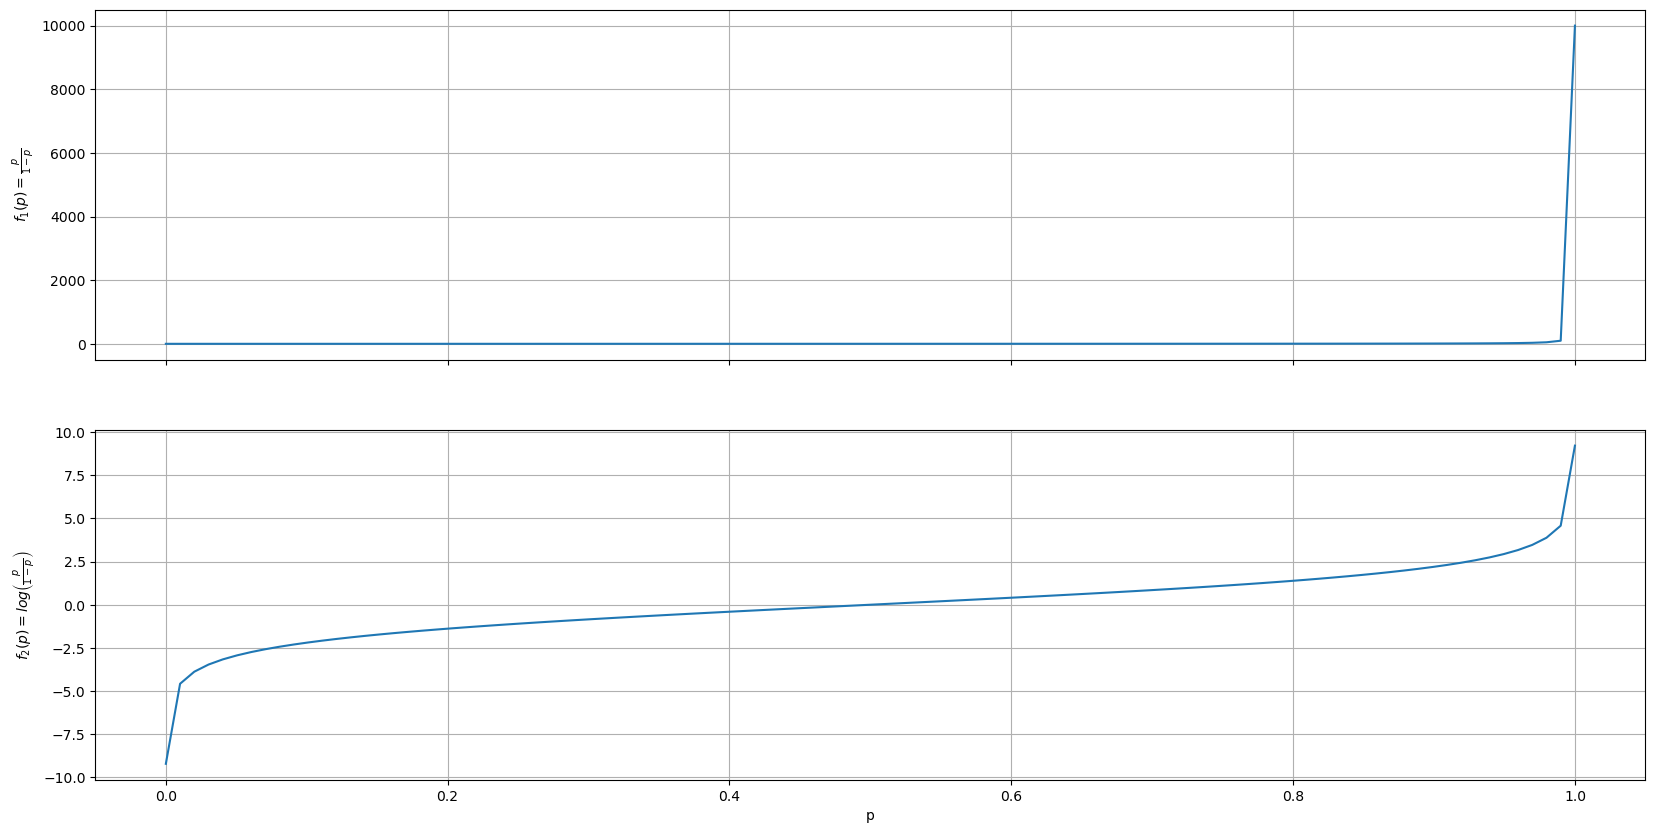

In [2]:
FuncType = Callable[[Union[float, np.ndarray]], Union[float, np.ndarray]]

f1: FuncType = lambda x: x / (1 - x)
f2: FuncType = lambda x: np.log(x / (1 - x))
x: np.ndarray = np.linspace(1e-4, 1-1e-4, 100)

fig, ax = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
ax[0].plot(x, f1(x)) ; ax[1].plot(x, f2(x))
ax[0].set_ylabel(r'$f_1(p) = \frac{p}{1-p}$') ; ax[0].grid()
ax[1].set_xlabel('p') ; ax[1].set_ylabel(r'$f_2(p) = log\left(\frac{p}{1-p}\right)$') ; ax[1].grid()
plt.show()

## Importing Libraries, Reading Data Using Pandas DataFrame

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import Union

plt.rc('font', **{'size' : 18})

In [4]:
# File paths
path_train: str = './data/fashion-mnist_train.csv'
path_test: str = './data/fashion-mnist_test.csv'

# Reading the data using Pandas DataFrame
train_data: pd.DataFrame = pd.read_csv(path_train)
test_data: pd.DataFrame = pd.read_csv(path_test)

# Asserting the shape of the data to ensure correct loading
assert(train_data.shape) == (60000, 785), f'The file was not read correctly: read content has shape {train_data.shape}'
assert(test_data.shape) == (10000, 785), f'The file was not read correctly: read content has shape {test_data.shape}'

# Displaying the first 5 rows from the training dataset
train_data.head(5)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's separate the images from their labels in the dataset. The matrices `train_set` and `test_se`t contain the class (a digit from 0 to 9) in the first column, while the image is stored starting from column 1 to the end.

Slice into `train_x` only the images and into `train_y` only the class, and do the same for `test_x` and `test_y`.

In [5]:
# train_set and test_set are matrices that contain the class (a digit from 0 to 9) in the first column,
# and the image is stored from column 1 to the end.
# Slice into train_x only the images and into train_y only the class,
# and do the same for test_x and test_y

train_x: pd.DataFrame
train_y: pd.Series
test_x: pd.DataFrame
test_y: pd.Series

# Splitting the data into features and labels for both training and testing sets
train_x, train_y = train_data.iloc[:, 1:], train_data.iloc[:, 0]
test_x, test_y = test_data.iloc[:, 1:], test_data.iloc[:, 0]

# Asserting the shapes of the splits to ensure correct slicing
assert train_x.shape == (60000, 784)  # Images have been correctly sliced into 784 pixels
assert train_y.shape == (60000,)      # Labels are correctly sliced
assert test_x.shape == (10000, 784)   # Same checks for the test set
assert test_y.shape == (10000,)       # Proper label slicing


Let's visualize the dataset. We will display the first 16 rows from the training set.

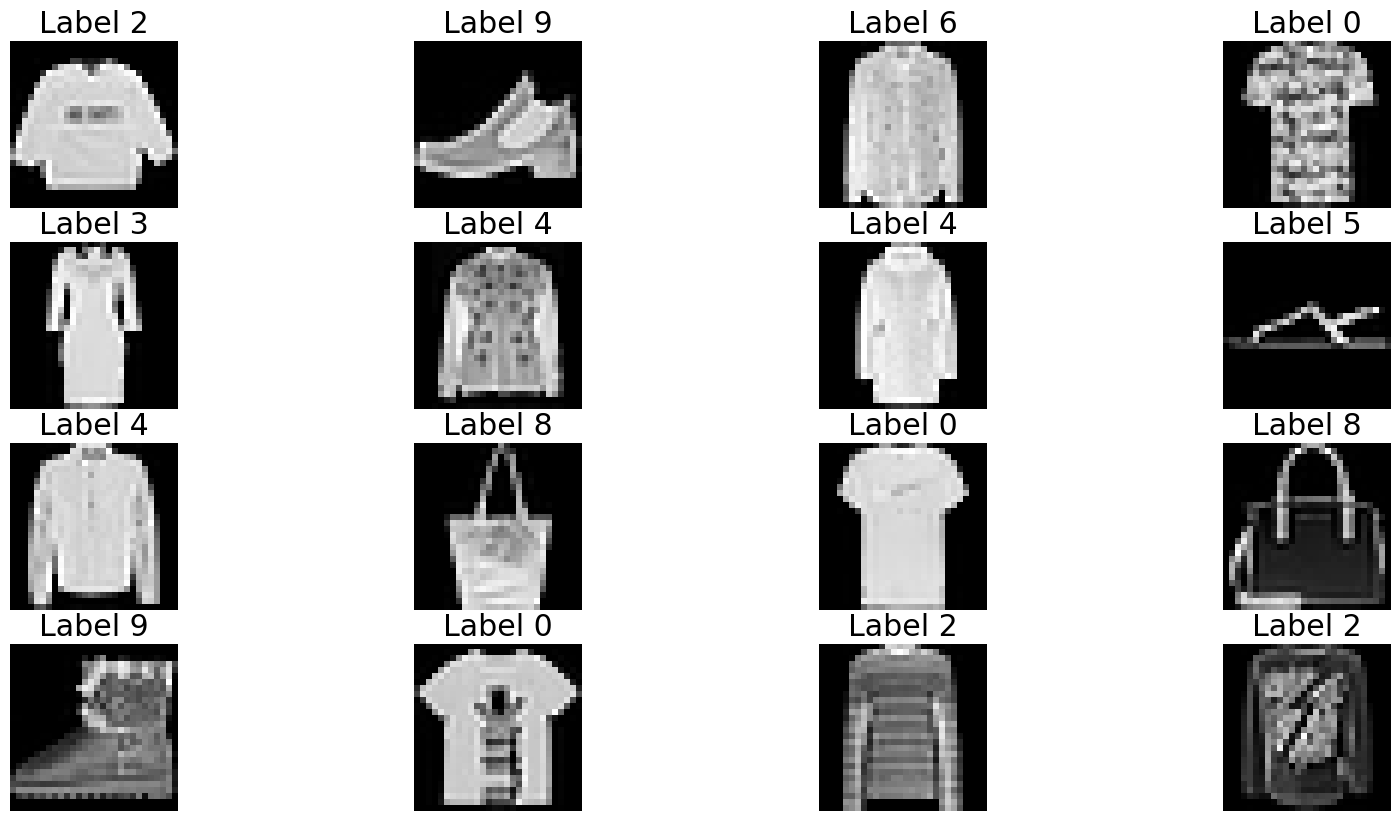

In [6]:
def show_samples(x_set: pd.DataFrame, y_set: pd.Series):
    """
    Visualizes a grid of images and their labels.
    
    :param x_set: DataFrame containing the image data, with each row representing an image.
    :param y_set: Series containing the class labels for each image in x_set.
    """
    size = x_set.shape[0]
    fig, ax = plt.subplots(size // 4, 4, figsize=(20, 10))
    
    for k in range(size):
        row, col = k // 4, k % 4
        pixels = np.array(x_set.iloc[k], dtype='uint8')
        n = int(np.sqrt(len(pixels)))
        assert n**2 == len(pixels), "Image data should form a perfect square"
        pixels = pixels.reshape(n, n)
        ax[row, col].imshow(pixels, cmap='gray')
        ax[row, col].set_title(f'Label {y_set.iloc[k]}')
        ax[row, col].axis('off')
    plt.show()
show_samples(train_x.iloc[:16, :], train_y.iloc[:16])

## Functions for data processing

To start, we will write the BINOMIAL regression algorithm. Therefore, we are interested in classifying only the images corresponding to two classes for now, for example for the classes '0' and '1', which are `T-shirt/top` and `Trouser`. We will define the sets that 'cut out' only these two classes from the given datasets:

In [7]:
# Filter out samples from the larger datasets that correspond to classes 0 and 1, namely "T-shirt/top" and "Trouser":
# Determine logical vectors with True for indices where classes in vector y are 0 or 1, and False otherwise

labels_0_1_train: pd.Series = (train_y == 0) | (train_y == 1)
labels_0_1_test: pd.Series = (test_y == 0) | (test_y == 1)

assert labels_0_1_train.shape == (60000,)
assert labels_0_1_test.shape == (10000,)

assert labels_0_1_train.sum() == 12000  # Total samples for classes 0 and 1 in the training set
assert labels_0_1_test.sum() == 2000    # Total samples for classes 0 and 1 in the test set

# Filter out samples from the larger sets that only correspond to classes 0 and 1.
# You can use reshape for the y vectors
# Use the logical vectors labels_0_1_train and labels_0_1_test for filtering

train_x_bin: pd.DataFrame
train_y_bin: np.ndarray
test_x_bin: pd.DataFrame
test_y_bin: np.ndarray

train_x_bin, train_y_bin = train_x[labels_0_1_train], train_y[labels_0_1_train].to_numpy().reshape(-1, 1)
test_x_bin, test_y_bin = test_x[labels_0_1_test], test_y[labels_0_1_test].to_numpy().reshape(-1, 1)

#print(train_x_bin)
#print(train_y_bin)

assert train_y_bin.shape == (12000, 1)  # Check the shape of the training labels after filtering
assert test_x_bin.shape == (2000, 784)  # Check the shape of the test features
assert test_y_bin.shape == (2000, 1)    # Check the shape of the test labels

The function below adds a column of 1s to a matrix to represent the weight for the intercept term

In [8]:
def augment_matrix(x: np.ndarray) -> np.ndarray:
    """
    Returns a matrix with first column filled with 1 and the other columns being x's columns.
    """
    result: np.ndarray = np.hstack((np.ones((x.shape[0], 1)), x))
    return result

train_x_bin_ext: np.ndarray = augment_matrix(train_x_bin)
test_x_bin_ext: np.ndarray = augment_matrix(test_x_bin)

assert train_x_bin_ext.shape == (12000, 785)
assert test_x_bin_ext.shape == (2000, 785)
assert np.all(train_x_bin_ext[:, 0] == 1)
assert np.all(test_x_bin_ext[:, 0] == 1)

The following function needs to take a matrix and scale each column (feature) to the range [0, 1] (similar to scaling with minimum and maximum values in linear regression). As these are pixel values, the maximum value is 255. Therefore, normalization will simply involve dividing the features by the maximum value, 255.

In [9]:

def normalize(x: np.ndarray) -> np.ndarray:
    """
    Normalization means division by 255.The following function needs to take a matrix and scale each column (feature) to the range [0, 1] (similar to scaling with minimum and maximum values in linear regression). As these are pixel values, the maximum value is 255. Therefore, normalization will simply involve dividing the features by the maximum value, 255.
    
    Args:
        x: feature matrix, shape m * n. It will not be changed by this code.
    
    Returns:
        matrix with scaled values between 0 and 1, of same shape
    """
    return x/255.0

train_x_bin_ext: np.ndarray = augment_matrix(normalize(train_x_bin))
test_x_bin_ext: np.ndarray = augment_matrix(normalize(test_x_bin))

assert train_x_bin_ext.shape == (12000, 785)
assert test_x_bin_ext.shape == (2000, 785)
assert np.all(train_x_bin_ext[:, 0] == 1)
assert np.all(test_x_bin_ext[:, 0] == 1)
assert np.all(train_x_bin_ext <= 1)
assert np.all(test_x_bin_ext <= 1)
assert np.all(train_x_bin_ext >= 0)
assert np.all(test_x_bin_ext >= 0)

## Functii pentru antrenare

We will calculate the sigmoid function:

$$
sigmoid(z) = \frac{1}{1 + e^{-z}}$$
and 
$$
\hat y = h(x, \theta) = sigmoid \left( X  \theta \right)
$$


In [10]:
def sigmoid(z: Union[float, np.ndarray]) -> Union[float, np.ndarray]:
    z = np.clip(z, -600, 600)
    return 1 / (1 + np.exp(-z))

assert sigmoid(0) == 0.5
assert np.abs(sigmoid(1) - 0.731058) < 1e-6

def h(x: Union[float, np.ndarray], theta: Union[float, np.ndarray]) -> Union[float, np.ndarray]:
    return sigmoid(x @ theta)

assert np.abs(h(np.array([1., 1., 1., 0]), np.array([1., 0., 1., 1.])) - 0.880797) < 1e-6

We will calculate the cost function with regularization this time (note that the coefficient $\theta_0$ is not regularized):

\begin{align}
J(\boldsymbol\theta) & = \underbrace{-\frac{1}{m} \sum\limits_{i=1}^m \left[y^{(i)}\cdot \ln h_{\boldsymbol\theta}(\mathbf{x}^{(i)}) + (1-y^{(i)})\cdot \ln (1- h_{\boldsymbol\theta}(\mathbf{x}^{(i)})) \right]}_{\text{Quality error}} 
\\
& + \underbrace{\frac{\lambda}{2} \sum\limits_{j=1}^n \theta_j^2}_{\text{regularization term}}
\\
& = 
\underbrace{-\frac{1}{m} \sum\limits_{i=1}^m \left[y^{(i)}\cdot \ln \hat y^{(i)}  + (1-y^{(i)})\cdot \ln (1- \hat y^{(i)}) \right]}_{\text{Quality error}} 
\\
& + \underbrace{\frac{\lambda}{2} \sum\limits_{j=1}^n \theta_j^2}_{\text{regularization term}}
\\
& = -\frac{1}{m} \left(\mathbf{y}^t \cdot \ln\hat{\mathbf{y}}  + (\mathbb{1}-\mathbf{y})^t \cdot \ln(\mathbb{1}-\hat{\mathbf{y}})\right) + \| \boldsymbol\theta[1:]  \|^2_2
\end{align}

where $\boldsymbol\theta[1:]$ is the vector formed from all components of $\boldsymbol\theta$ excluding the first one. $\| \mathbf{v} \|_2$ is the Euclidean norm of the vector $\mathbf{v}$.

In [11]:
epsilon = 1e-1

def cost(x: np.ndarray, y: np.ndarray, theta: np.ndarray, lmbda: float) -> float:
    """
    Cost function that also includes regularization.
    
    Args:
        x: The feature matrix, size m x (n+1)
        y: The evidence vector, size m x 1
        theta: The coefficients vector, size (n+1) x 1
        
    Returns:
        The cost as a scalar.
    """
    assert x.shape[1] == theta.shape[0]  # Ensures x and theta dimensions match
    assert x.shape[0] == y.shape[0]      # Ensures x and y have same number of samples
    assert theta.shape[1] == y.shape[1] == 1  # Ensures theta and y are columns vectors
    assert lmbda >= 0                    # Lambda for regularization must be non-negative
     
    # Compute the predicted values using the sigmoid function
    y_hat: np.ndarray = sigmoid(np.dot(x, theta))
    m: int = x.shape[0]  # Number of samples
    
    # First part of the cost function (without regularization)
    j1: float = (-1/m) * np.sum(y * np.log(y_hat + epsilon) + (1 - y) * np.log(1 - y_hat + epsilon))
    
    # Second part of the cost function (regularization term)
    j2: float = (lmbda / (2 * m)) * np.sum(np.square(theta[1:]))  # Exclude theta[0] from regularization
    
    return j1 + j2

np.random.seed(11)
n: int = train_x_bin_ext.shape[1]  # Assuming train_x_bin_ext is the feature matrix with intercept
theta: np.ndarray = np.random.randn(n).reshape(n, 1)  # Initialize theta randomly


Calculate the gradient using the previously determined expression, and taking into account the regularization term:

$$
\nabla_{\boldsymbol{\theta}} J(\boldsymbol{\theta}) = \frac{1}{m} \mathbf{X}^t(\hat{\mathbf{y}} - \mathbf{y}) + \lambda (0, \theta_1, \dots, \theta_n)
$$

In [12]:
def grad(x: np.ndarray, y: np.ndarray, theta: np.ndarray, lmbda: float) -> np.ndarray:
    """
    Computation of gradient with regularization term.
    
    Args:
        x: Feature matrix, size m x (n + 1)
        y: Evidence vector, size m
        theta: Coefficients vector, size n+1
        lmbda: Regularization coefficient
        
    Returns:
        The gradient, an n+1 element vector.
    """
   
    m: int = x.shape[0]  # Number of samples
    y_hat: np.ndarray = sigmoid(np.dot(x, theta))  # Predicted probabilities
    g1: np.ndarray = (1/m) * np.dot(x.T, (y_hat - y))  # Gradient of the cost function, without regularization
    
    theta_simple: np.ndarray = theta.copy()  # Copy of theta to manipulate for regularization
    theta_simple[0] = 0  # Exclude the bias term from regularization
    g2: np.ndarray = (lmbda/m) * theta_simple  # Gradient for the regularization term
    
    g: np.ndarray = g1 + g2  # Total gradient
    assert g.shape == theta.shape  # Ensure the gradient's shape matches theta's
    return g

np.random.seed(11)
n: int = train_x_bin_ext.shape[1]  # Assume train_x_bin_ext includes an intercept term
theta: np.ndarray = np.random.randn(n).reshape(n, 1)  # Initialize theta
res: np.ndarray = grad(train_x_bin_ext, train_y_bin, theta=theta, lmbda=0.2)  # Compute the gradient
assert res.shape == (785, 1)  # Verify the shape of the result


The training algorithm will store the cost associated with each epoch in a list:

In [13]:
def compute_accuracy(x_set: np.ndarray, y_set: np.ndarray, theta: np.ndarray) -> float:
    pred: np.ndarray = ((h(x_set, theta) >= 0.5) * 1 == y_set)
    return 100.0 * sum(pred) / pred.shape[0]

In [14]:
# Set learning rate
eta: float = 0.2

# Set regularization coefficient
lmbda: float = 0.5

# In x, we have m instances of n features each
# Create theta as a vector (n x 1)
n: int = np.shape(train_x_bin_ext)[1]
theta: np.ndarray = np.random.randn(n).reshape(n, 1)

# Do the training
epochs: int = 40
values: np.ndarray = []
accurracies: np.ndarray = []
for i in range(epochs):
    theta -= eta * grad(train_x_bin_ext, train_y_bin, theta, lmbda)
    acc = compute_accuracy(train_x_bin_ext, train_y_bin, theta)
    values.append(cost(train_x_bin_ext, train_y_bin, theta, lmbda))
    accurracies.append(acc)
    
print("last cost: %g" % values[-1])

last cost: 0.0934416


Graphical representation of the cost function and accuracy:

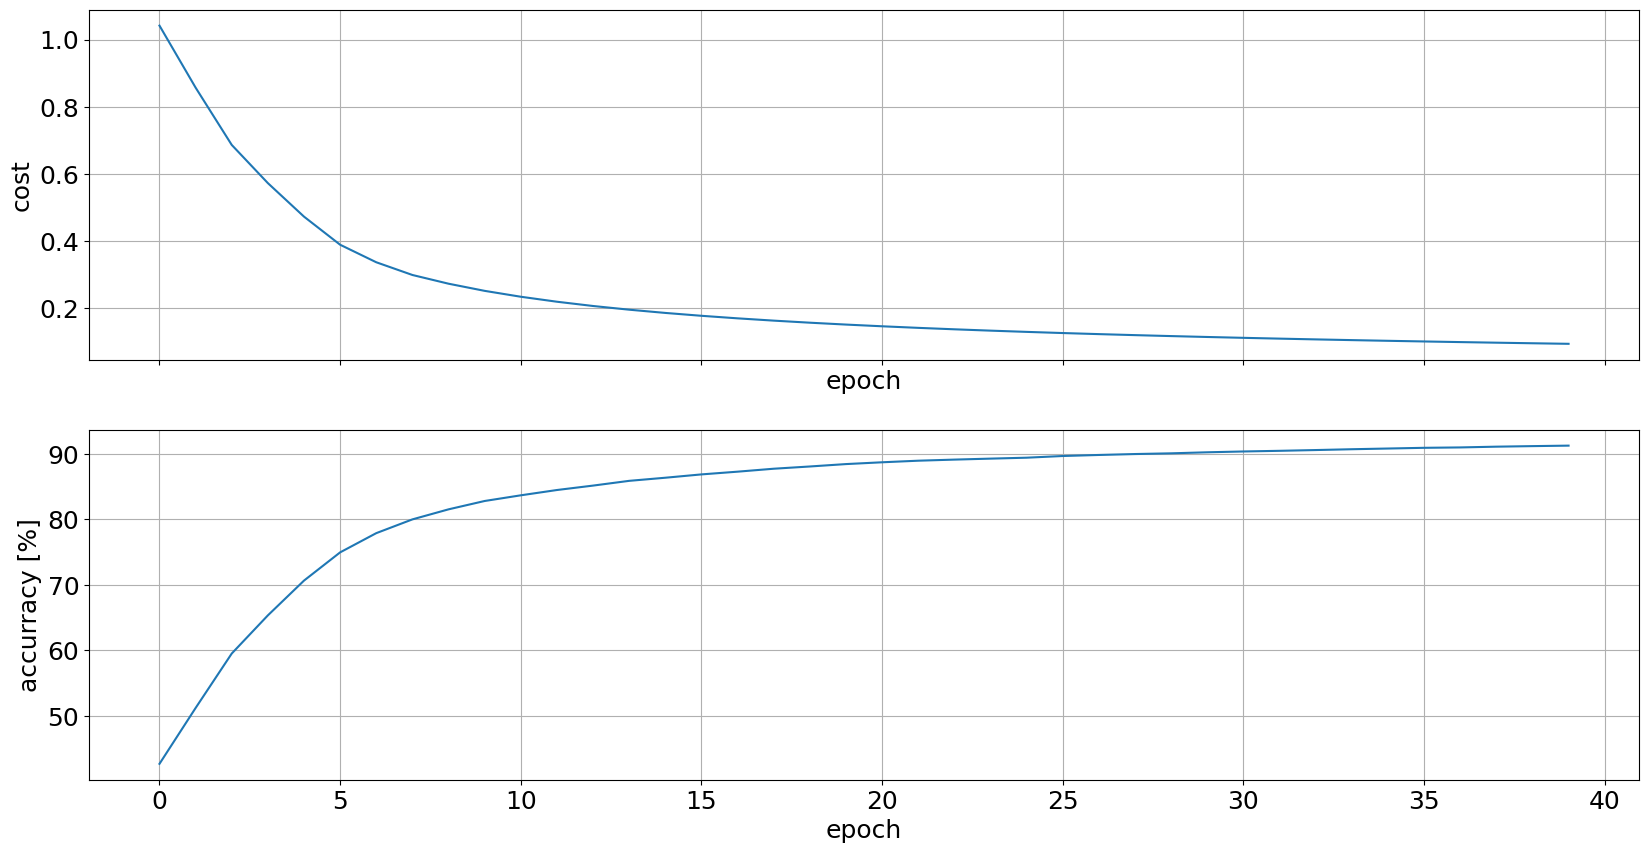

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
ax[0].plot(range(len(values)), values)
ax[0].set_xlabel('epoch') ; ax[0].set_ylabel('cost')
ax[0].grid()
ax[1].plot(range(len(accurracies)), accurracies)
ax[1].set_xlabel('epoch') ; ax[1].set_ylabel('accurracy [%]')
ax[1].grid()
plt.show()

## Matricea de confuzie

Next, we will represent the confusion matrix, a tool that helps us visualize the performance of our algorithm. Thus, we can identify false positives and/or false negatives. The confusion matrix will display at the intersection of row/column how many samples from the class given by the row number were predicted as belonging to the class given by the column number.

In [16]:
!pip install tableprint 
import tableprint as tab

In [17]:
# Calculate accuracy for the test set
# This involves counting how many predictions match reality and expressing this percentage-wise
pred = ((h(test_x_bin_ext, theta) >= 0.5) * 1 == test_y_bin)
print("Accuracy: %2.2f%% for %d patterns" % (compute_accuracy(test_x_bin_ext, test_y_bin, theta), test_x_bin_ext.shape[0]))

# Calculation of the confusion matrix
pred = (h(test_x_bin_ext, theta) >= 0.5) * 1
tp = np.sum((pred == 1) & (test_y_bin == 1))  # True positives
tn = np.sum((pred == 0) & (test_y_bin == 0))  # True negatives
fp = np.sum((pred == 1) & (test_y_bin == 0))  # False positives
fn = np.sum((pred == 0) & (test_y_bin == 1))  # False negatives

headers = ['Confusion Matrix', 'Pred: 0', 'Pred: 1', 'Pred: All']
table = [
    ['Actual: 0', tn, fp, tn + fp],
    ['Actual: 1', fn, tp, fn + tp],
    ['Actual: All', tn + fn, fp + tp, tn + fn + fp + tp]]
tab.table(table, headers, width=16)

Accuracy: 91.85% for 2000 patterns
╭──────────────────┬──────────────────┬──────────────────┬──────────────────╮
│ Confusion Matrix │          Pred: 0 │          Pred: 1 │        Pred: All │
├──────────────────┼──────────────────┼──────────────────┼──────────────────┤
│        Actual: 0 │              914 │               86 │             1000 │
│        Actual: 1 │               77 │              923 │             1000 │
│      Actual: All │              991 │             1009 │             2000 │
╰──────────────────┴──────────────────┴──────────────────┴──────────────────╯


## Multinomial Regression

Next we will implement the multinomial regression model. We will train the model to classify all images in the dataset, using all 10 classes.

To begin with, for the entire training set:
* we will normalize the feature matrix
* we will add a column of 1s, corresponding to the intercept term.

In [18]:
# Number of classes
k: int = 10

# Adding a column of 1s to the features (for the intercept term)
train_x_all_ext: np.ndarray = augment_matrix(normalize(train_x))
test_x_all_ext: np.ndarray = augment_matrix(normalize(test_x))

# Assert statements to verify the correct transformation of the data
assert train_x_all_ext.shape == (60000, 785)
assert test_x_all_ext.shape == (10000, 785)
assert np.all(train_x_all_ext[:, 0] == 1)
assert np.all(test_x_all_ext[:, 0] == 1)
assert np.all(train_x_all_ext <= 1)
assert np.all(test_x_all_ext <= 1)
assert np.all(train_x_all_ext >= 0)
assert np.all(test_x_all_ext >= 0)

Next, we will perform 'one-hot encoding', which converts an integer to a binary array that has a 1 only at a specified position. 
Specifically, in our case, each class will be encoded into a k-dimensional vector (k=10=number of classes), consisting of zeros and a 1 at the position corresponding to the class.

For example:
* 4 becomes `[0 0 0 0 1 0 0 0 0 0]`
* 0 becomes `[1 0 0 0 0 0 0 0 0 0]`

In [19]:
def one_hot(val: int, classes: int) -> np.ndarray:
    """
    Performs 'one-hot encoding', converting an integer into a binary array,
    with a 1 at the position specified by 'val'.
    
    Args:
        val: The class to be encoded, an integer between {0, 1, ... K-1}
        classes: The number of classes K
        
    Returns:
        An array of zeros with shape (1, classes), with a 1 only at the position 'val'
    """
    assert 0 <= val < classes  # Ensure the class value is within the expected range
    
    # Create a one-hot encoded vector using numpy's eye function
    return np.eye(classes)[val].reshape(1, classes)

k = 10  # Number of classes
assert np.all(one_hot(7, k) == np.array([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]]))
assert np.all(one_hot(3, k) == np.array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]]))

# Applying one-hot encoding to all labels in the training and test datasets
train_y_all: np.ndarray = np.concatenate([one_hot(int(i), k) for i in train_y])
test_y_all: np.ndarray = np.concatenate([one_hot(int(i), k) for i in test_y])

# Assert statements to verify the final shapes and values of the encoded arrays
assert train_y_all.shape == (60000, 10)  # Check if the one-hot encoded training labels have the correct shape
assert test_y_all.shape == (10000, 10)  # Check if the one-hot encoded test labels have the correct shape
assert np.all((train_y_all != 0) == (train_y_all == 1))  # Ensure all entries are either 0 or 1


When we compute the product between matrix $X$, of dimension $(m, n)$, and $\theta$, of dimension $(n, k)$, we obtain the result $X \theta$, of dimension $(m, k)$, where:

* $m$ = number of samples (images)
* $n$ = number of features
* $k$ = number of classes

The $softmax()$ function will have the same dimensions $(m, k)$ and must produce a sum of $1$ for each column. Its calculation can be compactly written as:

$$softmax(X, \theta) = \frac{e^{X \theta}}{e^{X \theta} \cdot \mathbb{1}_k}$$

The term in the denominator, $e^{X \theta} \cdot \mathbb{1}_k$, is not a matrix but a vector of dimension $(m, 1)$ (essentially summing each row). The division is carried out using the broadcasting operation.

In [20]:
# We will check the dimensions of the result from X @ Theta
m: int = train_x_all_ext.shape[0]  # number of samples
n: int = train_x_all_ext.shape[1]  # number of features including the bias term
np.random.seed(11)  # Setting seed for reproducibility
theta: np.ndarray = np.random.randn(n, k)  # Randomly initializing theta matrix for n features and k classes
assert (train_x_all_ext @ theta).shape == (m, k)  # Verifying the shape of the product matches expected dimensions

In [21]:
def softmax(x: np.ndarray, theta: np.ndarray) -> np.ndarray:
    """
    Computes the softmax function.
    
    Args:
        x: Features, size m x n
        theta: Parameters, size n x k
        
    Returns:
        The softmax function result, size m x k
    """
    # Ensure that the number of features in x matches the number of rows in theta
    assert x.shape[1] == theta.shape[0]
    
    # Calculate the linear transformation of the input features
    z: np.ndarray = np.dot(x, theta)
    
    # Apply the softmax function to the linear transformation
    exp_z: np.ndarray = np.exp(z - np.max(z, axis=1, keepdims=True))
    
    # Normalize the exponentiated values to obtain probabilities
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

# Apply softmax function to the feature matrix
smax: np.ndarray = softmax(train_x_all_ext, theta)
    
assert smax.shape == (m, k)# Assertion to check the dimensions of the softmax output
assert np.all((smax.sum(axis=1) - 1) < 1e-12)# Assertion to verify that sum of probabilities across each row is approximately 1

The cost function that includes the regularization can be written more compactly as follows (notice the summation index $𝑖$ starting from 1):

$$J(\theta, \lambda) = -\frac{1}{m} \mathbb{1}_m^T \left\{ Y \odot \log[softmax(X \theta)] \mathbb{1}_k \right\} + \frac{\lambda}{2} \sum_{i=1}^{n-1}\sum_{j=0}^{k-1} \theta_{i,j}^2 = -\frac{1}{m} \mathbb{1}_m^T \left\{ Y \odot \log[softmax(X \theta)] \mathbb{1}_k \right\} + \frac{\lambda}{2} \|\Theta[1:, :]\|_F^2$$

where for a matrix $A$ of type $m\times n$, $\| A \|_F$ is Forbenius norm: $$\| A \|_F = \sqrt{\sum\limits_{i=0}^{m-1}\sum\limits_{j=0}^{n-1} |a_{ij}|^2}$$

In [22]:
def cost(x: np.ndarray, y: np.ndarray, theta: np.ndarray, lmbda: float) -> float:
    """
    Computes the cost function with regularization.
    
    Args:
        x: Features, size m x n
        y: Classes, size m x k
        theta: Parameters, size n x k
        lmbda: Regularization parameter, scalar
        
    Returns:
        The cost, as a scalar
    """
    m: int = x.shape[0]  # Number of samples
    
    # Compute the predicted probabilities using the softmax function
    y_hat: np.ndarray = softmax(x, theta)
    
    # Compute the cross-entropy loss term
    j1: float = -np.sum(y * np.log(y_hat)) / m
    
    # Compute the regularization term
    j2: float = (lmbda / 2) * np.linalg.norm(theta[1:, :], 'fro')**2
    
    # Total cost is the sum of the cross-entropy loss and regularization term
    return j1 + j2

The gradient is calculated as follows:

$$\nabla_{\theta}J = - \frac{1}{m} X^T \left[Y - softmax(X \theta) \right] + \lambda \left[ \mathbb{0}_n, \theta_{1 \dots k-1} \right]$$

Where the matrix $\left[ \mathbb{0}_n, \theta_{1 \dots k-1} \right]$ have the size (n, k), as $\theta$, except that the first line is zero.

In [23]:

def deltas(x: np.ndarray, y: np.ndarray, theta: np.ndarray, lmbda: float) -> np.ndarray:
    """
    Calculeaza gradientul

    Args:
        x: feature-urile, dimensiune m x n
        y: clasele, de dimensiune m x k
        theta: parametrii, de dimensiune n x k
        lmbda: parametrul de regularizare, scalar
        
    Returns:
        matricea gradientilor, de dimensiunea lui theta (n x k)
    """
    m: int = x.shape[0]
    
    smax: np.adarray = softmax(x, theta)
    
    grad_cross_entropy: np.adarray = -np.dot(x.T, (y - smax)) / m
    
    theta_reg: np.adarray = theta.copy()
    theta_reg[0, :] = 0
    grad_regularization = lmbda * theta_reg

    return grad_cross_entropy + grad_regularization

m: int = train_x_all_ext.shape[0]
n: int = train_x_all_ext.shape[1]
np.random.seed(11)
theta: np.ndarray = np.random.randn(n, k)
grad: np.ndarray = deltas(train_x_all_ext, train_y_all, theta=theta, lmbda=0.2)

assert grad.shape == (n, k)

In [24]:
def deltas(x: np.ndarray, y: np.ndarray, theta: np.ndarray, lmbda: float) -> np.ndarray:
    """
    Computes the gradients.

    Args:
        x: Features, size m x n
        y: Classes, size m x k
        theta: Parameters, size n x k
        lmbda: Regularization parameter, scalar
        
    Returns:
        The matrix of gradients, with the same dimensions as theta (n x k)
    """
    m: int = x.shape[0]  # Number of samples
    
    # Compute the predicted probabilities using the softmax function
    smax: np.ndarray = softmax(x, theta)
    
    # Compute the gradient of the cross-entropy loss term
    grad_cross_entropy: np.ndarray = -np.dot(x.T, (y - smax)) / m
    
    # Compute the gradient of the regularization term
    theta_reg: np.ndarray = theta.copy()
    theta_reg[0, :] = 0  # Exclude regularization for the bias term
    grad_regularization: np.ndarray = lmbda * theta_reg
    
    # Combine the gradients of the cross-entropy loss and regularization terms
    return grad_cross_entropy + grad_regularization

theta: np.ndarray = np.random.randn(n, k)  # Randomly initialize parameters theta
grad: np.ndarray = deltas(train_x_all_ext, train_y_all, theta=theta, lmbda=0.2)

assert grad.shape == (n, k)

Let's calculate the accuracy of the model:

In [25]:
def calculate_accurracy(set_x: np.ndarray, set_y: np.ndarray, theta: np.ndarray) -> float:
    probabilities: np.ndarray = softmax(set_x, theta)
    
    # Select the class with the highest probability
    predictions:np.ndarray = np.argmax(probabilities, axis=1)
    
    # Convert set_y to the same format for comparison
    actual: np.ndarray = np.argmax(set_y, axis=1)
    
    # Calculate and return accuracy
    accuracy: float = np.mean(predictions == actual) * 100.0
    return accuracy

Let's train the multinomial regression model:

In [26]:
# Number of classes
k: int = 10

lmbda:float = 0.05
alpha: float = 1.1
m: int = train_x_all_ext.shape[0]
n: int = train_x_all_ext.shape[1]
np.random.seed(11)
theta: np.ndarray = np.random.randn(n, k)

epochs: int = 300
values: np.ndarray = []
accurracies : np.ndarray = []
for i in range(epochs):
    theta -= alpha * deltas(train_x_all_ext, train_y_all, theta, lmbda)
    if (i % 10 == 0):
        values.append(cost(train_x_all_ext, train_y_all, theta, lmbda))
        accurracies.append(calculate_accurracy(test_x_all_ext, test_y_all, theta))
        print("epoch: ", i, "cost: ", values[-1], "accuracy: ", accurracies[-1])
        lmbda *= 0.9
    
print("last costs: %g" % values[-1])

epoch:  0 cost:  194.75309947586254 accuracy:  9.71
epoch:  10 cost:  67.09213774907168 accuracy:  46.14
epoch:  20 cost:  32.28710032354387 accuracy:  40.839999999999996
epoch:  30 cost:  19.89840632569937 accuracy:  47.160000000000004
epoch:  40 cost:  15.10681012180924 accuracy:  50.44
epoch:  50 cost:  13.549337739360219 accuracy:  65.16999999999999
epoch:  60 cost:  6.572385034817226 accuracy:  57.96
epoch:  70 cost:  6.82014976168408 accuracy:  45.82
epoch:  80 cost:  6.426067286316486 accuracy:  63.13999999999999
epoch:  90 cost:  7.598556364093999 accuracy:  55.54
epoch:  100 cost:  6.961813439090192 accuracy:  52.190000000000005
epoch:  110 cost:  2.8164741735860837 accuracy:  66.84
epoch:  120 cost:  2.7227942980130266 accuracy:  66.8
epoch:  130 cost:  5.9102538227988 accuracy:  57.76
epoch:  140 cost:  6.027219885816328 accuracy:  65.36999999999999
epoch:  150 cost:  7.065858367701645 accuracy:  60.08
epoch:  160 cost:  5.89277158712788 accuracy:  66.86
epoch:  170 cost:  5

We will plot the accuracy and cost function for our model:

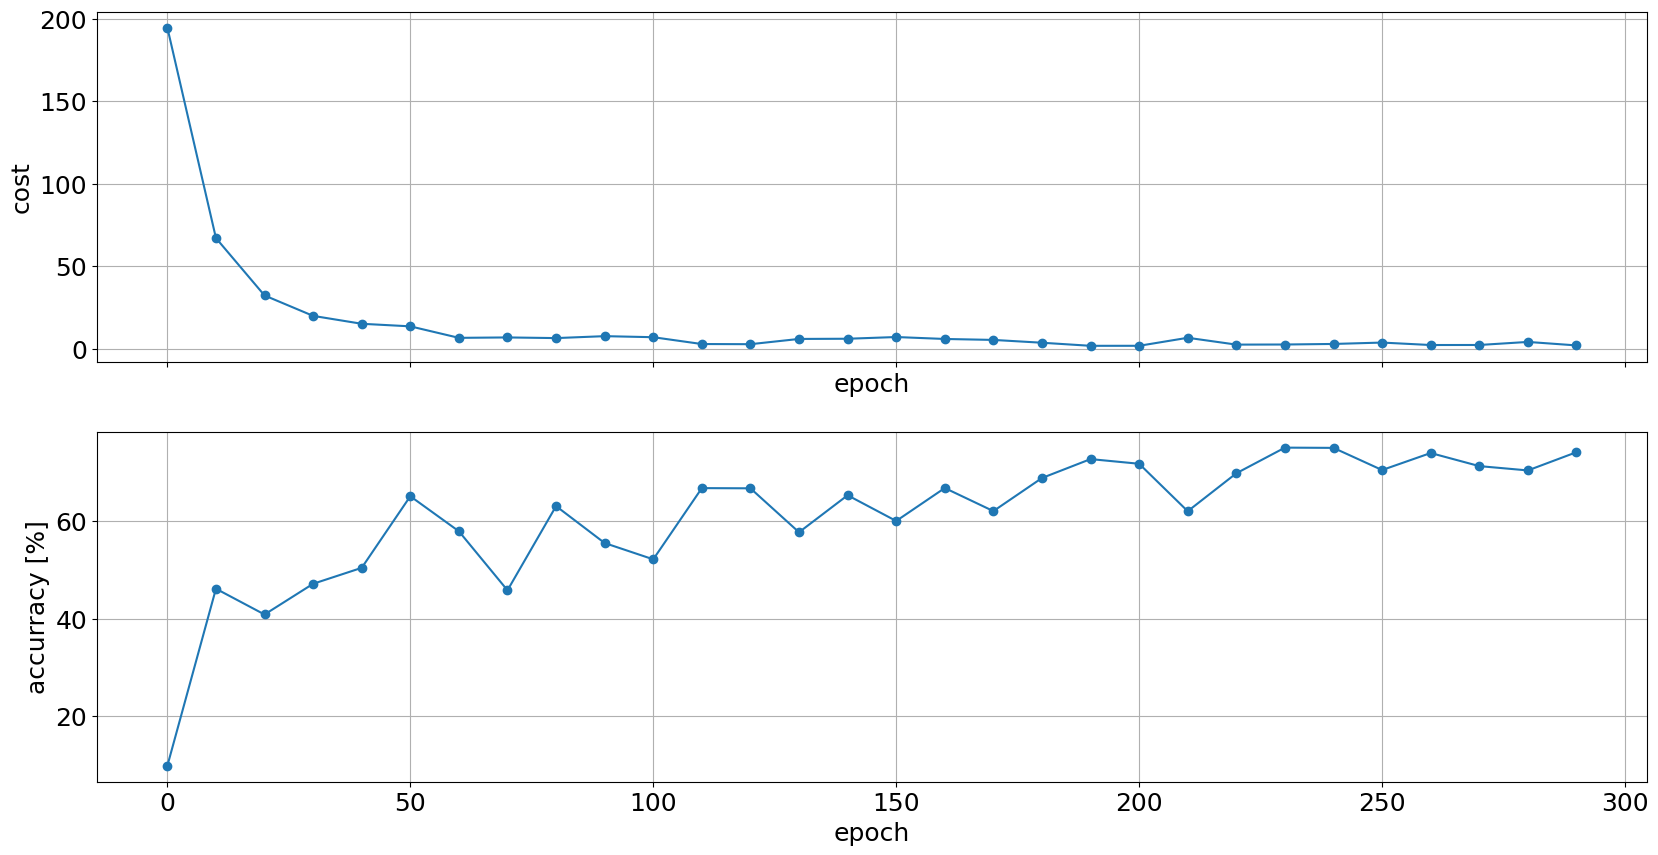

In [27]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
ax[0].plot([x * 10 for x in range(len(values))], values, 'o-')
ax[0].set_xlabel('epoch') ; ax[0].set_ylabel('cost')
ax[0].grid()
ax[1].plot([x * 10 for x in range(len(accurracies))], accurracies, 'o-')
ax[1].set_xlabel('epoch') ; ax[1].set_ylabel('accurracy [%]')
ax[1].grid()
plt.show()

## Multinomial regression model testing

Let's calculate the accuracy for the test set. This involves counting how many predictions match reality and expressing this as a percentage:

In [28]:
pred: np.ndarray = np.argmax(softmax(test_x_all_ext, theta), axis=1)
actual: np.ndarray = np.argmax(test_y_all, axis=1) if test_y_all.ndim > 1 else test_y_all
equalities: int = np.sum(pred == actual)
accuracy: float = (equalities / len(actual)) * 100
print("Test accuracy: %2.2f%% for %d patterns" % (accuracy, len(actual)))

Test accuracy: 76.56% for 10000 patterns


### Confusion Matrix

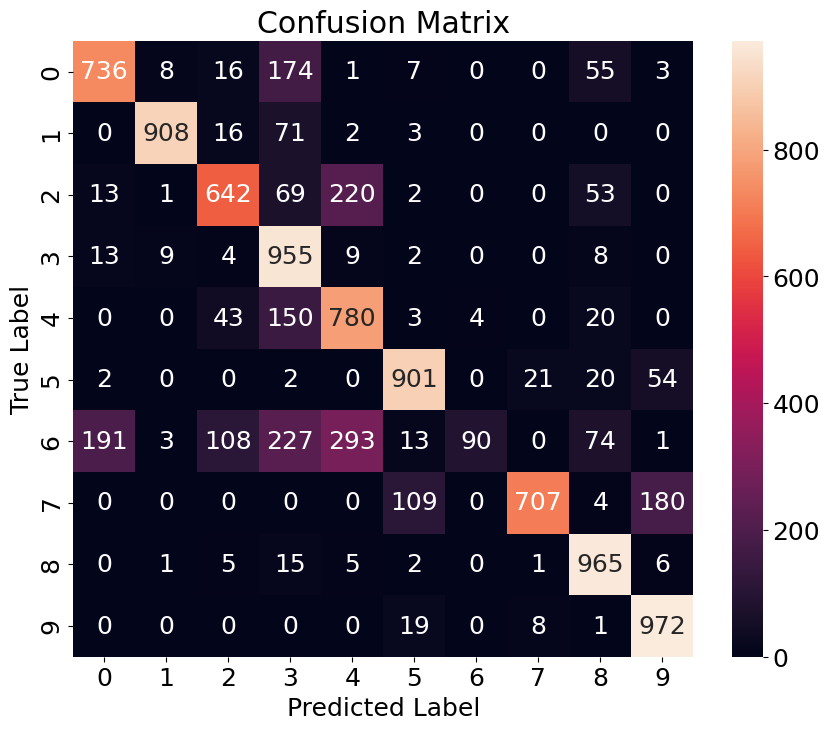

In [29]:
# Compute the confusion matrix manually
conf_matrix = np.zeros((k, k), dtype=int)
for a, p in zip(actual, pred):
    conf_matrix[a, p] += 1

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=range(k), yticklabels=range(k))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()